In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist, obs_hci
from pynrc.obs_nircam import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches

pynrc.setup_logging('WARNING', verbose=False)

# Observation Definitions

Functions to create and optimize a series of observation objects stored as a dictionary.

In [3]:
def make_key(filter, pupil=None, mask=None):
    """Create identification key (string) based on filter, pupil, and mask"""
    mask_key = 'none' if mask is None else mask
    pupil_key = 'none' if pupil is None else pupil
    key = '{}_{}_{}'.format(filter,mask_key,pupil_key)
    return key

In [4]:
def model_info(source, filt, dist):
    
    base_dir  = '/Volumes/NIRData/Andras_models_v2/'
    model_dir = base_dir + source + '/'
    
    # Match filters with model
    filt_switch = {'F182M':'F210M', 'F210M':'F210M', 'F250M':'F250M',
                   'F300M':'F300M', 'F335M':'F335M', 'F444W':'F444W'}
    filt_model = filt_switch.get(filt, filt)
    fname = source + '_' + filt_model +'sc.fits'

    bp = nrc_utils.read_filter(filt_model)
    w0 = bp.avgwave() / 1e4

    # Model pixels are 4x oversampled
    detscale = (nrc_utils.channel_select(bp))[0]
    model_scale = detscale / 4.
    
    # File name, arcsec/pix, dist (pc), wavelength (um), flux units
    args_model = (model_dir+fname, model_scale, dist, w0, 'Jy/pixel')

    return args_model

In [5]:
def obs_wfe(wfe_drift, filt_list, sp_sci, dist, sp_ref=None, args_disk='auto', 
            wind_mode='WINDOW', subsize=None, fov_pix=None, verbose=False, narrow=False):
    """
    For a given WFE drift and series of filters, create a list of 
    NIRCam observations.
    """
    
    if sp_ref is None: sp_ref = sp_sci

    obs_dict = {}
    for filt, mask, pupil in filt_list:
        # Create identification key
        key = make_key(filt, mask=mask, pupil=pupil)
        print(key)

        # Disk Model
        if args_disk is None:
            hdu_disk = None
        elif 'auto' in args_disk:
            # Convert to photons/sec in specified filter
            args_disk = model_info(sp_sci.name, filt, dist)
            hdu_disk = model_to_hdulist(args_disk, sp_sci, filt, pupil=pupil, mask=mask)
        else:
            hdu_disk = model_to_hdulist(args_disk, sp_sci, filt, pupil=pupil, mask=mask)
            
        fov_pix_orig = fov_pix
        # Define the subarray readout size
        if 'FULL' in wind_mode: # Full frame
            subuse = 2048
            
            # Define PSF pixel size
            if mask is None: 
                fov_pix = 400 if fov_pix is None else fov_pix
            elif ('210R' in mask) or ('SWB' in mask): 
                fov_pix = 640 if fov_pix is None else fov_pix
            else:
                fov_pix = 320 if fov_pix is None else fov_pix
                
        elif subsize is None: # Window Mode defaults
            if mask is None: # Direct Imaging
                subuse = 400
            elif ('210R' in mask) or ('SWB' in mask): # SW Coronagraphy
                subuse = 640
            else: # LW Coronagraphy
                subuse = 320
        else: # No effect if full frame
            subuse = subsize
                
        # Define PSF pixel size
        fov_pix = subuse if fov_pix is None else fov_pix

        # Make sure fov_pix is odd for direct imaging
        if (mask is None) and (np.mod(fov_pix,2)==0):
            fov_pix += 1
        # Other coronagraph vs direct imaging settings
        module, oversample = ('B', 4) if mask is None else ('A', 2)
        
        if narrow and ('SWB' in mask):
            bar_offset=-8
        elif narrow and ('LWB' in mask):
            bar_offset=8
        else:
            bar_offset=None
        
        # Initialize and store the observation
        # A reference observation is stored inside each parent obs_hci class.
        obs_dict[key] = pynrc.obs_hci(sp_sci, sp_ref, dist, filter=filt, mask=mask, pupil=pupil, 
                                      wfe_ref_drift=wfe_drift, fov_pix=fov_pix, oversample=oversample, 
                                      wind_mode=wind_mode, xpix=subuse, ypix=subuse,
                                      disk_hdu=hdu_disk, verbose=verbose, bar_offset=bar_offset)
        fov_pix = fov_pix_orig
        
    return obs_dict

In [6]:
def obs_optimize(obs_dict, sp_opt=None, well_levels=None, tacq_max=1800, **kwargs):
    """
    Perform ramp optimization on each science and reference observation
    in a list of filter observations. Updates the detector MULTIACCUM
    settings for each observation in the dictionary.
    
    snr_goal = 5
    snr_frac = 0.02
    tacq_max = 1400
    tacq_frac = 0.01
    nint_min = 15
    ng_max = 10
    """

    # A very faint bg object on which to maximize S/N
    # If sp_opt is not set, then default to a 20th magnitude flat source
    if sp_opt is None:
        bp_k = S.ObsBandpass('k')
        sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)

    
    # Some observations may saturate, so define a list of  maximum well level
    # values that we will incrementally check until a ramp setting is found
    # that meets the contraints.
    if well_levels is None:
        well_levels = [0.8, 1.5, 3.0, 5.0, 10.0, 20.0, 100.0, 150.0, 300.0, 500.0]
   
    filt_keys = list(obs_dict.keys())
    filt_keys.sort()
    print(['Pattern', 'NGRP', 'NINT', 't_int', 't_exp', 't_acq', 'SNR', 'Well', 'eff'])
    for j, key in enumerate(filt_keys):
        print('')
        print(key)

        obs = obs_dict[key]
        sp_sci, sp_ref = (obs.sp_sci, obs.sp_ref)
        
        # SW filter piggy-back on two LW filters, so 2 x tacq
        is_SW = obs.bandpass.avgwave()/1e4 < 2.5

        sci = obs
        ref = sci.nrc_ref

        # Ramp optimization for both science and reference targets
        for obs2, sp in zip([sci, ref], [sp_sci, sp_ref]):
            i = nrow = 0
            while nrow==0:
                well_max = well_levels[i]
                tbl = obs2.ramp_optimize(sp_opt, sp, well_frac_max=well_max, tacq_max=tacq_max, **kwargs)
                nrow = len(tbl)
                i+=1
                
            # Grab the highest ranked MULTIACCUM settings and update the detector readout
            v1, v2, v3 = tbl['Pattern', 'NGRP', 'NINT'][0]
            
            vals = tbl[0].as_void()
            strout = ', '.join(map(str, vals))
            print(strout)

            # SW filter piggy-back on two LW filters, so 2 x tacq
            is_SW = obs.bandpass.avgwave()/1e4 < 2.5
            if is_SW: v3 *= 2
            
            # Coronagraphic observations have two roll positions, so cut NINT by 2
            if obs.mask is not None: v3 = int(v3/2) 
            obs2.update_detectors(read_mode=v1, ngroup=v2, nint=v3)
        

## Functions to run series of operations

In [7]:
# Optimize observations
def do_opt(tacq_max, **kwargs):
    sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)
    obs_optimize(obs_dict, sp_opt=sp_opt, tacq_max=tacq_max, **kwargs)

In [8]:
# For each filter setting, generate a series of contrast curves at different WFE values
def do_contrast(obs_dict, wfe_list, filt_keys, nsig=5, roll_angle=10, **kwargs):
    """
    kwargs to pass to calc_contrast() and their defaults:

    no_ref = False
    func_std = robust.medabsdev
    exclude_disk = True
    exclude_planets = True
    exclude_noise = False
    opt_diff = True
    fix_sat = False
    ref_scale_all = False
    """
    contrast_all = {}
    for i, key in enumerate(filt_keys):
        print(key)
        obs = obs_dict[key]

        wfe_roll_temp = obs.wfe_roll_drift
        wfe_ref_temp  = obs.wfe_ref_drift

        # Stores tuple of (Radial Distances, Contrast, and Sensitivity) for each WFE drift
        curves = []
        for wfe_drift in wfe_list:
            
            
            if ('no_ref' in list(kwargs.keys())) and (kwargs['no_ref']==True):
                obs.wfe_roll_drift = wfe_drift
            else:
                obs.wfe_ref_drift = wfe_drift
            result = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, **kwargs)
            curves.append(result)
            
        obs.wfe_roll_drift = wfe_roll_temp
        obs.wfe_ref_drift = wfe_ref_temp
            
        contrast_all[key] = curves
    return contrast_all

In [9]:
def do_gen_hdus(obs_dict, wfe_ref_drift, verbose=False, **kwargs):
    
    """
    kwargs to pass to gen_roll_image() and their defaults:
    
    PA1 = 0
    PA2 = 10
    zfact         = None
    oversample    = None
    exclude_disk  = False
    exclude_noise = False
    opt_diff      = True
    use_cmask     = False
    """
    
    hdulist_dict = {}
    for key in filt_keys:
        if verbose: print(key)
        obs = obs_dict[key]
        obs.wfe_ref_drift = wfe_ref_drift
        hdulist = obs.gen_roll_image(**kwargs)
        
        hdulist_dict[key] = hdulist
        
    return hdulist_dict

In [10]:
from pynrc.nrc_utils import coron_ap_locs
def do_sat_levels(obs, satval=0.95, ng_min=2, ng_max=None, plot=True, xylim=2.5, verbose=True):
    
    ng_max = obs.det_info['ngroup'] if ng_max is None else ng_max
    
    # Well level of each pixel for science source
    image = obs.gen_slope_image(exclude_noise=True, use_cmask=True, quick_PSF=True)
    sci_levels1 = obs.saturation_levels(ngroup=ng_min, image=image)
    sci_levels2 = obs.saturation_levels(ngroup=ng_max, image=image)

    # Well level of each pixel for reference source
    image = obs.gen_slope_image(exclude_noise=True, use_cmask=True, quick_PSF=True, do_ref=True)
    ref_levels1 = obs.saturation_levels(ngroup=ng_min, image=image, do_ref=True)
    ref_levels2 = obs.saturation_levels(ngroup=ng_max, image=image, do_ref=True)
    
    # Which pixels are saturated?
    sci_mask1 = sci_levels1 > satval
    sci_mask2 = sci_levels2 > satval

    # Which pixels are saturated?
    ref_mask1 = ref_levels1 > satval
    ref_mask2 = ref_levels2 > satval

    # How many saturated pixels?
    nsat1_sci = len(sci_levels1[sci_mask1])
    nsat2_sci = len(sci_levels2[sci_mask2])

    # How many saturated pixels?
    nsat1_ref = len(ref_levels1[ref_mask1])
    nsat2_ref = len(ref_levels2[ref_mask2])

    if verbose:
        print(obs.sp_sci.name)
        print('{} saturated pixel at NGROUP=2'.format(nsat1_sci))
        print('{} saturated pixel at NGROUP={}'.format(nsat2_sci,ng_max))
        print('')
        print(obs.sp_ref.name)
        print('{} saturated pixel at NGROUP=2'.format(nsat1_ref))
        print('{} saturated pixel at NGROUP={}'.format(nsat2_ref,ng_max))
        
    if nsat2_sci==nsat2_ref==0:
        plot=False
        if verbose:
            print('')
            print('No saturation detected.')

    if plot:
        fig, axes_all = plt.subplots(2,2, figsize=(8,8))

        xlim = ylim = np.array([-1,1])*xylim

        
        # Plot science source
        nsat1, nsat2 = (nsat1_sci, nsat2_sci)
        sat_mask1, sat_mask2 = (sci_mask1, sci_mask2)
        sp = obs.sp_sci
        nrc = obs

        xpix, ypix = (nrc.det_info['xpix'], nrc.det_info['ypix'])
        bar_offpix = nrc.bar_offset / nrc.pixelscale
        if ('FULL' in nrc.det_info['wind_mode']) and (nrc.mask is not None):
            cdict = coron_ap_locs(nrc.module, nrc.channel, nrc.mask, full=True)
            xcen, ycen = cdict['cen_V23']
            xcen += bar_offpix
        else:
            xcen, ycen = (xpix/2 + bar_offpix, ypix/2)
        delx, dely = (xcen - xpix/2, ycen - ypix/2)
        
        extent_pix = np.array([-xpix/2-delx,xpix/2-delx,-ypix/2-dely,ypix/2-dely])
        extent = extent_pix * nrc.pix_scale

        axes = axes_all[0]
        axes[0].imshow(sat_mask1, extent=extent)
        axes[1].imshow(sat_mask2, extent=extent)

        axes[0].set_title('{} Saturation (NGROUP=2)'.format(sp.name))
        axes[1].set_title('{} Saturation (NGROUP={})'.format(sp.name,ng_max))

        for ax in axes:
            ax.set_xlabel('Arcsec')
            ax.set_ylabel('Arcsec')

            ax.tick_params(axis='both', color='white', which='both')
            for k in ax.spines.keys():
                ax.spines[k].set_color('white')

            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

        # Plot ref source sat mask
        nsat1, nsat2 = (nsat1_ref, nsat2_ref)
        sat_mask1, sat_mask2 = (ref_mask1, ref_mask2)
        sp = obs.sp_ref
        nrc = obs.nrc_ref

        axes = axes_all[1]
        axes[0].imshow(sat_mask1, extent=extent)
        axes[1].imshow(sat_mask2, extent=extent)

        axes[0].set_title('{} Saturation (NGROUP=2)'.format(sp.name))
        axes[1].set_title('{} Saturation (NGROUP={})'.format(sp.name,ng_max))

        for ax in axes:
            ax.set_xlabel('Arcsec')
            ax.set_ylabel('Arcsec')

            ax.tick_params(axis='both', color='white', which='both')
            for k in ax.spines.keys():
                ax.spines[k].set_color('white')

            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

        fig.tight_layout()
        
    #masks = [[sci_mask1,sci_mask2], [ref_mask1,ref_mask2]]
        
    # Return saturation radius
    if nsat1_sci == nsat1_ref == 0:
        sat_rad = 0
    else:
        sat_mask = sci_mask1 if nsat1_sci > nsat1_ref else ref_mask1
        rho = nrc_utils.dist_image(sat_mask, center=(xcen,ycen))
        sat_rad = rho[sat_mask].max() * obs.pixelscale
        
    return sat_rad

## Functions to plot images and contrast curves

In [11]:
from copy import deepcopy
from pynrc.nrc_utils import dist_image, pad_or_cut_to_size

def plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=10, save_fig=False):
    nfilt = len(filt_keys)
    ext_name = ['Model', 'Sim Image (linear scale)', 'Sim Image ($r^2$ scale)']
    nim = len(ext_name)

    fig, axes = plt.subplots(nfilt, nim, figsize=(8.5,6.5))
    #axes = axes.transpose()
    for j, k in enumerate(filt_keys):
        obs = obs_dict[k]
        hdu_mod = obs.disk_hdulist
        hdu_sim = hdu_dict[k]
        data  = hdu_sim[0].data
        data -= np.nanmedian(data)

        # Make r^2 scaled version of data
        hdu_sim_r2 = deepcopy(hdu_sim)
        data  = hdu_sim_r2[0].data
        data -= np.nanmedian(data)
        header = hdu_sim_r2[0].header
        rho = dist_image(data, pixscale=header['PIXELSCL'])
        data *= rho**2

        # Max value for model
        data_mod   = hdu_mod[0].data
        header_mod = hdu_mod[0].header
        rho_mod    = dist_image(data_mod, pixscale=header_mod['PIXELSCL'])
        data_mod_r2 = data_mod*rho_mod**2
        vmax  = np.max(data_mod)
        vmax2 = np.max(data_mod_r2)

        # Scale value for data
        im_temp = pad_or_cut_to_size(data_mod, hdu_sim[0].data.shape)
        mask_good = im_temp>(0.1*vmax)
        scl1 = np.nanmedian(hdu_sim[0].data[mask_good] / im_temp[mask_good])
        scl1 = np.abs(scl1)

        # Scale value for r^2 version
        im_temp = pad_or_cut_to_size(data_mod_r2, hdu_sim_r2[0].data.shape)
        mask_good = im_temp>(0.1*vmax2)
        scl2 = np.nanmedian(hdu_sim_r2[0].data[mask_good] / im_temp[mask_good])
        scl2 = np.abs(scl2)

        vmax_vals = [vmax,vmax*scl1,vmax2*scl2]
        hdus = [hdu_mod, hdu_sim, hdu_sim_r2]
        for i, ax in enumerate(axes[j]):
            hdulist = hdus[i]
            data = hdulist[0].data
            header = hdulist[0].header

            pixscale = header['PIXELSCL']
            rho = dist_image(data, pixscale=pixscale)

            rad = data.shape[0] * pixscale / 2
            extent = [-rad, rad, -rad, rad]

            ax.imshow(data, vmin=0, vmax=0.9*vmax_vals[i], extent=extent)

            ax.set_aspect('equal')
            if i > 0: ax.set_yticklabels([])
            if j < nfilt-1: ax.set_xticklabels([])
            if j==nfilt-1: ax.set_xlabel('Arcsec')
            if j==0: ax.set_title(ext_name[i])

            if i==0: 
                texp = obs.multiaccum_times['t_exp']
                texp = round(2*texp/100)*100
                exp_text = "{:.0f} sec".format(texp)
                ax.set_title('{} ({})'.format(obs.filter, exp_text))

            xlim = [-fov/2,fov/2]
            ylim = [-fov/2,fov/2]
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

            ax.xaxis.get_major_locator().set_params(nbins=10, steps=[1, 2, 5, 10])
            ax.yaxis.get_major_locator().set_params(nbins=10, steps=[1, 2, 5, 10])

            ax.tick_params(axis='both', color='white', which='both')
            for k in ax.spines.keys():
                ax.spines[k].set_color('white')


    texp = obs_dict[filt_keys[-1]].multiaccum_times['t_exp']
    texp = round(2*texp/100)*100
    wfe_text = "WFE Drift = {} nm".format(wfe_drift)
    fig.suptitle('{} ({})'.format(name_sci, wfe_text), fontsize=16);
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.9, bottom=0.1)
    #fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.9, bottom=0.07 , left=0.05, right=0.97)
    
    fname = "{}_images_{}.pdf".format(name_sci.replace(" ", ""), obs.mask)
    if save_fig: 
        fig.savefig(outdir+fname)

In [12]:
from copy import deepcopy
from pynrc.nrc_utils import dist_image, pad_or_cut_to_size

def plot_images_swlw(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=10, save_fig=False):
    nfilt = len(filt_keys)
    ext_name = ['Model', 'Sim Image (linear scale)', 'Sim Image ($r^2$ scale)']
    nim = len(ext_name)

    fig, axes = plt.subplots(nim, nfilt, figsize=(14,7.5))
    axes = axes.transpose()
    for j, k in enumerate(filt_keys):
        obs = obs_dict[k]
        hdu_mod = obs.disk_hdulist
        hdu_sim = hdu_dict[k]
        data  = hdu_sim[0].data
        data -= np.nanmedian(data)

        # Make r^2 scaled version of data
        hdu_sim_r2 = deepcopy(hdu_sim)
        data  = hdu_sim_r2[0].data
        data -= np.nanmedian(data)
        header = hdu_sim_r2[0].header
        rho = dist_image(data, pixscale=header['PIXELSCL'])
        data *= rho**2

        # Max value for model
        data_mod   = hdu_mod[0].data
        header_mod = hdu_mod[0].header
        rho_mod    = dist_image(data_mod, pixscale=header_mod['PIXELSCL'])
        data_mod_r2 = data_mod*rho_mod**2
        vmax  = np.max(data_mod)
        vmax2 = np.max(data_mod_r2)
        
        # Scale value for data
        im_temp = pad_or_cut_to_size(data_mod, hdu_sim[0].data.shape)
        mask_good = im_temp>(0.1*vmax)
        scl1 = np.nanmedian(hdu_sim[0].data[mask_good] / im_temp[mask_good])
        scl1 = np.abs(scl1)
        
        # Scale value for r^2 version
        im_temp = pad_or_cut_to_size(data_mod_r2, hdu_sim_r2[0].data.shape)
        mask_good = im_temp>(0.1*vmax2)
        scl2 = np.nanmedian(hdu_sim_r2[0].data[mask_good] / im_temp[mask_good])
        scl2 = np.abs(scl2)

        vmax_vals = [vmax,vmax*scl1,vmax2*scl2]
        hdus = [hdu_mod, hdu_sim, hdu_sim_r2]
        for i, ax in enumerate(axes[j]):
            hdulist = hdus[i]
            data = hdulist[0].data
            header = hdulist[0].header

            pixscale = header['PIXELSCL']
            rho = dist_image(data, pixscale=pixscale)

            rad = data.shape[0] * pixscale / 2
            extent = [-rad, rad, -rad, rad]

            ax.imshow(data, vmin=0, vmax=0.9*vmax_vals[i], extent=extent)

            ax.set_aspect('equal')
            if j > 0: ax.set_yticklabels([])
            if i < nim-1: ax.set_xticklabels([])
            if i==nim-1: ax.set_xlabel('Arcsec')
            if j==0: ax.set_ylabel(ext_name[i])

            if i==0: 
                texp = obs.multiaccum_times['t_exp']
                texp = round(2*texp/100)*100
                exp_text = "{:.0f} sec".format(texp)
                ax.set_title('{} ({})'.format(obs.filter, exp_text))

            xlim = [-fov/2,fov/2]
            ylim = [-fov/2,fov/2]
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

            ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
            ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

            if fov<=2*rad:
                ax.tick_params(axis='both', color='white', which='both')
                for k in ax.spines.keys():
                    ax.spines[k].set_color('white')

            
    wfe_text = "WFE Drift = {} nm".format(wfe_drift)
    fig.suptitle('{} ({})'.format(name_sci, wfe_text), fontsize=16);
    fig.tight_layout()

    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.9, bottom=0.07 , left=0.05, right=0.97)
    
    fname = "{}_images_{}.pdf".format(name_sci.replace(" ", ""), obs.mask)
    if save_fig: 
        fig.savefig(outdir+fname)

In [13]:
from pynrc.nrc_utils import jupiter_spec
def do_plot_contrasts(curves_roll, curves_ref, obs, age2=None, save_fig=False, 
                      jup_mag=True, xr=[0,10], xr2=[0,10]):
    lin_vals = np.linspace(0.2,0.8,len(wfe_list))
    c2 = plt.cm.Reds_r(lin_vals)
    c3 = plt.cm.Purples_r(lin_vals)
    c4 = plt.cm.Greens_r(lin_vals)

    fig, axes = plt.subplots(1,2, figsize=(14,4.5))

    ax = axes[0]
    plot_contrasts(curves_roll, nsig, wfe_list, obs=obs, ax=ax)
    plot_contrasts(curves_ref, nsig, wfe_list, ax=ax, colors=c2, xr=xr)
    #plot_planet_patches(ax, obs, age=age, av_vals=None, cond=True)

    ax.set_ylim([22,8])


    # Legend organization
    nwfe = len(wfe_list)
    handles, labels = ax.get_legend_handles_labels()
    h1 = handles[0:nwfe]
    h2 = handles[nwfe:]
    h1_t = [mpatches.Patch(color='none', label='Ref Sub')]
    h2_t = [mpatches.Patch(color='none', label='Roll Sub')]
    handles_new = h1_t + h1 + h2_t + h2
    ax.legend(ncol=2, handles=handles_new, loc='upper right')
    
    # Magnitude of Jupiter at object's distance
    jspec = jupiter_spec(dist=obs.distance)
    jobs = S.Observation(jspec, obs.bandpass, binset=obs.bandpass.wave)
    jmag = jobs.effstim('vegamag')
    if jmag<np.max(ax.get_ylim()):
        ax.plot(xr, [jmag,jmag], color='C2', ls='--')
        txt = 'Jupiter at {:.1f} pc'.format(obs.distance)
        ax.text(xr[0]+0.02*(xr[1]-xr[0]), jmag, txt, horizontalalignment='left', verticalalignment='bottom')

    # Plot in terms of Jupiter Masses
    ax = axes[1]
    age1 = age
    plot_contrasts_mjup(curves_roll, nsig, wfe_list, obs=obs, age=age1, ax=ax, twin_ax=True, yr=None)
    plot_contrasts_mjup(curves_ref, nsig, wfe_list, obs=obs, age=age1, ax=ax, colors=c2, xr=xr2, yr=None)
    if age2 is not None:
        plot_contrasts_mjup(curves_roll, nsig, wfe_list, obs=obs, age=age2, ax=ax, colors=c3, yr=None)
        plot_contrasts_mjup(curves_ref, nsig, wfe_list, obs=obs, age=age2, ax=ax, colors=c4, xr=xr2, yr=None)

        # Legend organization
        handles, labels = ax.get_legend_handles_labels()
        handles_new = [handles[i*nwfe] for i in range(4)]
        labels_new = ['Ref Sub ({:.0f} Myr)'.format(age1),
                      'Roll Sub ({:.0f} Myr)'.format(age1),
                      'Ref Sub ({:.0f} Myr)'.format(age2),
                      'Roll Sub ({:.0f} Myr)'.format(age2),
                     ]
    else:
        handles, labels = ax.get_legend_handles_labels()
        handles_new = [handles[i*nwfe] for i in range(2)]
        labels_new = ['Ref Sub ({:.0f} Myr)'.format(age1),
                      'Roll Sub ({:.0f} Myr)'.format(age1),
                     ]
    ax.legend(handles=handles_new, labels=labels_new, loc='upper right', title='COND Models')
        
    # Some fancy log+linear plotting
    from matplotlib.ticker import FixedLocator, ScalarFormatter
    ax.set_ylim([0,100])
    yr = ax.get_ylim()
    ax.set_yscale('symlog', linthreshy=10, linscaley=2)
    ax.set_yticks(list(range(0,10)) + [10,100,1000])
    #ax.get_yaxis().set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())

    minor_log = list(np.arange(20,100,10)) + list(np.arange(200,1000,100))
    minorLocator = FixedLocator(minor_log)
    ax.yaxis.set_minor_locator(minorLocator)
    ax.set_ylim([0,yr[1]])

    # Saturation regions
    if sat_rad > 0:
        sat_rad_asec = sat_rad
        for ax in axes:
            ylim = ax.get_ylim()
            rect = mpatches.Rectangle((0, ylim[0]), sat_rad, ylim[1]-ylim[0], alpha=0.2, color='k', zorder=2)
            ax.add_patch(rect)


    title_str = '{} (dist = {:.1f} pc; PSF Ref: {}) -- {} Contrast Curves'\
        .format(name_sci, obs.distance, name_ref, obs.filter)
    fig.suptitle(title_str, fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

    fname = "{}_contrast_{}.pdf".format(name_sci.replace(" ", ""), obs.mask)
    if save_fig: 
        fig.savefig(outdir+fname)

## Define Sources and their Reference PSF Stars

In [14]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [15]:
#                source,      dist, age, sptype, Teff, [Fe/H], log_g, mag, band, fov
args_sources = [('HD10647',  17.34, 1400, 'F9V', 5954, +0.00, 4.7, 4.34, bp_k, 13),
                ('HD107146', 27.47,  200, 'G2V', 5850, +0.00, 4.5, 5.54, bp_k, 13),
                ('HD181327', 48.21,   12, 'F6V', 6449, +0.29, 4.4, 5.91, bp_k,  7),
                ('HD61005',  36.49,  100, 'G8V', 5500, +0.00, 4.5, 6.45, bp_k,  7),
                ('HD32297', 132.79,   30, 'A7V', 7800, -0.76, 3.8, 7.59, bp_k,  5),
               ]

ref_sources  = [('iotHor',   'F8V',  6080, +0.15, 4.5, 4.14, bp_k),
                ('HD111398', 'G5V',  5689, +0.07, 4.5, 5.53, bp_k),
                ('HR7297',   'F7V',  6500, -0.10, 4.2, 5.10, bp_k),
                ('HD56161',  'G5IV', 5337, +0.00, 4.3, 4.91, bp_k),
                ('HD31411',  'A0V',  9500, +0.00, 4.0, 6.42, bp_k)]

In [16]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

# Directory to save plots and figures
outdir  = 'DebrisDisks/'

In [17]:
# List of filters
args_filter = [('F182M', 'MASK335R', 'CIRCLYOT'),
               ('F210M', 'MASK335R', 'CIRCLYOT'),
               ('F250M', 'MASK335R', 'CIRCLYOT'),
               ('F300M', 'MASK335R', 'CIRCLYOT'),
               ('F335M', 'MASK335R', 'CIRCLYOT'),
               ('F444W', 'MASK335R', 'CIRCLYOT')]

subsize = 320

#args_filter = [('F335M', 'MASK335R', 'CIRCLYOT'),
#               ('F444W', 'MASK335R', 'CIRCLYOT')]

filt_keys = []
for filt,mask,pupil in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

## HD 10647

In [18]:
# Fit spectrum to SED photometry
from pynrc.nrc_utils import source_spectrum

i=0
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci, fov = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,4])

# Final source spectrum
sp_sci = src.sp_model

Warning, 1 of 43 bins contained negative fluxes; they have been set to zero.
[1.0135502]


In [19]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True)

# Final reference spectrum
sp_ref = ref.sp_model

Warning, 1 of 31 bins contained negative fluxes; they have been set to zero.
[1.01410814]


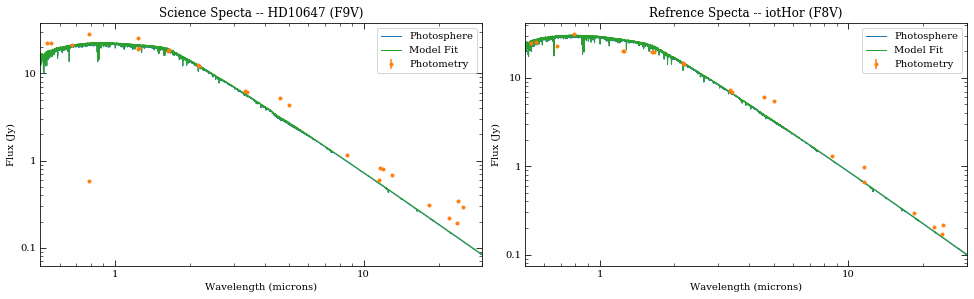

In [20]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Refrence Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

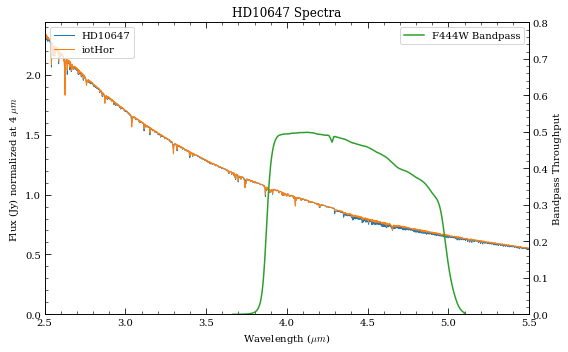

In [21]:
# Plot the two spectra
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3.9) & (w<=4.1)
    sp.convert('Jy')
    f = sp.flux / np.mean(sp.flux[ind2])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    ax.set_ylabel('Flux (Jy) normalized at 4 $\mu m$')
    sp.convert('flam')

ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
bp = pynrc.read_filter(*args_filter[-1])
ax2 = ax.twinx()
ax2.plot(bp.wave/1e4, bp.throughput, color='C2', label=bp.name+' Bandpass')
ax2.set_ylim([0,0.8])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_2SEDs.pdf'.format(name_sci.replace(' ','')))

In [22]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F182M_MASK335R_CIRCLYOT
F210M_MASK335R_CIRCLYOT
F250M_MASK335R_CIRCLYOT
F300M_MASK335R_CIRCLYOT
F335M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [23]:
# Optimize readout parameters
tacq = 4200
# patterns=['BRIGHT2']
# do_opt(tacq, patterns=patterns, ng_min=5, ng_max=10, tacq_frac=0.1, well_levels=[2], even_nints=True)

In [24]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    ng, nint_sci, nint_ref = (8,23,25)
    if obs.bandpass.avgwave()/1e4 < 2.5: 
        nint_sci *= 2
        nint_ref *= 2
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_ref)

#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')


In [25]:
# Saturation Levels
# Only want F444W
#obs = obs_dict[filt_keys[-1]]
#sat_rad = do_sat_levels(obs, plot=True)

# Max Saturation Values
dmax = []
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    
    imsci = obs.gen_slope_image(exclude_noise=True, quick_PSF=True)
    imref = obs.gen_slope_image(exclude_noise=True, quick_PSF=True, do_ref=True)
    
    ng1 = 2
    ng2 = obs.multiaccum.ngroup
    sci_sat1 = obs.saturation_levels(ngroup=ng1, image=imsci)
    sci_sat2 = obs.saturation_levels(ngroup=ng2, image=imsci)
    ref_sat1 = obs.saturation_levels(ngroup=ng1, image=imref, do_ref=True)
    ref_sat2 = obs.saturation_levels(ngroup=ng2, image=imref, do_ref=True)
    
    print('Max Well NG={}: {:.2f} {:.2f};   Max Well NG={}: {:.2f} {:.2f}'\
          .format(ng1,sci_sat1.max(),ref_sat1.max(),ng2,sci_sat2.max(),ref_sat2.max()))


F182M_MASK335R_CIRCLYOT
Max Well NG=2: 0.52 0.62;   Max Well NG=8: 2.24 2.70
F210M_MASK335R_CIRCLYOT
Max Well NG=2: 0.59 0.70;   Max Well NG=8: 2.54 3.05
F250M_MASK335R_CIRCLYOT
Max Well NG=2: 0.33 0.40;   Max Well NG=8: 1.45 1.74
F300M_MASK335R_CIRCLYOT
Max Well NG=2: 0.24 0.29;   Max Well NG=8: 1.04 1.24
F335M_MASK335R_CIRCLYOT
Max Well NG=2: 0.19 0.23;   Max Well NG=8: 0.82 0.98
F444W_MASK335R_CIRCLYOT
Max Well NG=2: 0.12 0.14;   Max Well NG=8: 0.52 0.62


In [26]:
# Disk Images
wfe_drift = 5
hdu_dict = do_gen_hdus(obs_dict, wfe_drift, PA1=-5, PA2=-15, opt_diff=False, use_cmask=True)

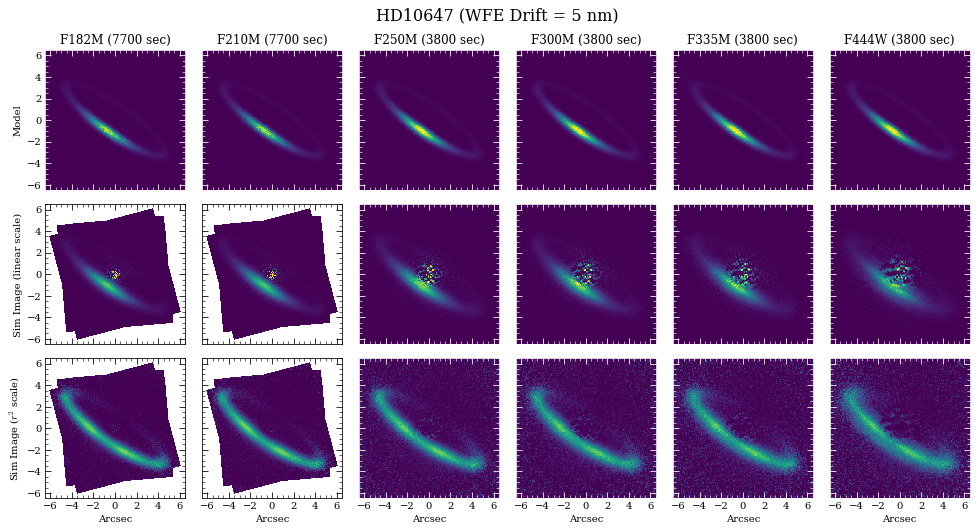

In [27]:
save_fig = True
if len(obs_dict)==2:
    plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_fig)
else:
    plot_images_swlw(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_fig)

In [28]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_dict = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, exclude_disk=False)
curves_F444W = curves_dict[filt_keys[-1]]

# Roll1 - Roll2
curves_dict = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, exclude_disk=False,
                          no_ref=True)
curves_F444W2 = curves_dict[filt_keys[-1]]

F444W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


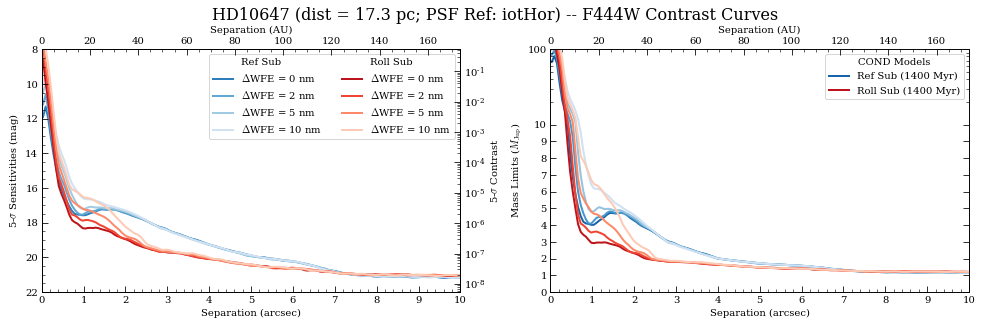

In [29]:
sat_rad = 0
obs = obs_dict[filt_keys[-1]]
do_plot_contrasts(curves_F444W, curves_F444W2, obs, save_fig=True)

## HD 107146

In [30]:
# Fit spectrum to SED photometry
from pynrc.nrc_utils import source_spectrum

i=1
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci, fov = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,4])

# Final source spectrum
sp_sci = src.sp_model

[1.00911793]


In [31]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True)

# Final reference spectrum
sp_ref = ref.sp_model

[1.04390456]


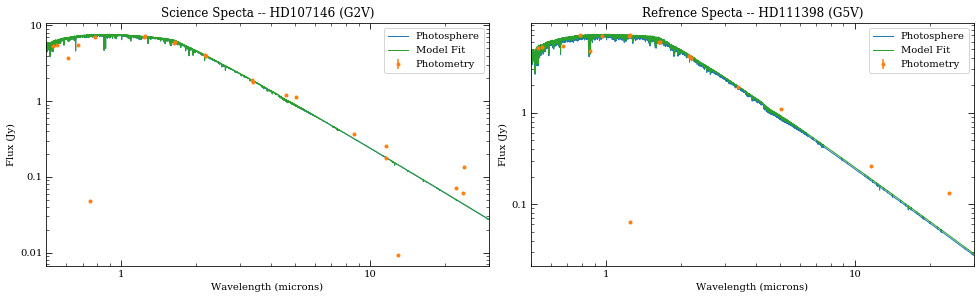

In [32]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Refrence Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

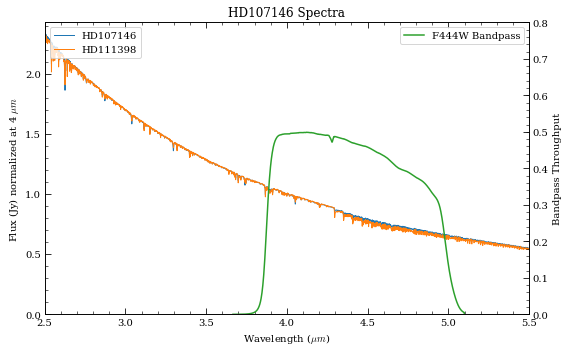

In [33]:
# Plot the two spectra
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3.9) & (w<=4.1)
    sp.convert('Jy')
    f = sp.flux / np.mean(sp.flux[ind2])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    ax.set_ylabel('Flux (Jy) normalized at 4 $\mu m$')
    sp.convert('flam')

ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
bp = pynrc.read_filter(*args_filter[-1])
ax2 = ax.twinx()
ax2.plot(bp.wave/1e4, bp.throughput, color='C2', label=bp.name+' Bandpass')
ax2.set_ylim([0,0.8])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_2SEDs.pdf'.format(name_sci.replace(' ','')))

In [34]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F182M_MASK335R_CIRCLYOT
F210M_MASK335R_CIRCLYOT
F250M_MASK335R_CIRCLYOT
F300M_MASK335R_CIRCLYOT
F335M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [35]:
# Optimize readout parameters
tacq = 4200
#do_opt(tacq, patterns='MEDIUM8', ng_min=8, ng_max=8, tacq_frac=0.1, well_levels=[2], even_nints=True)

In [36]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    ng, nint_sci, nint_ref = (10,18,20)
    if obs.bandpass.avgwave()/1e4 < 2.5: 
        nint_sci *= 2
        nint_ref *= 2
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_ref)

    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')


In [37]:
# Saturation Levels
# Only want F444W
#obs = obs_dict[filt_keys[-1]]
#sat_rad = do_sat_levels(obs, plot=True)

# Max Saturation Values
dmax = []
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    
    imsci = obs.gen_slope_image(exclude_noise=True, quick_PSF=True)
    imref = obs.gen_slope_image(exclude_noise=True, quick_PSF=True, do_ref=True)
    
    ng1 = 2
    ng2 = obs.multiaccum.ngroup
    sci_sat1 = obs.saturation_levels(ngroup=ng1, image=imsci)
    sci_sat2 = obs.saturation_levels(ngroup=ng2, image=imsci)
    ref_sat1 = obs.saturation_levels(ngroup=ng1, image=imref, do_ref=True)
    ref_sat2 = obs.saturation_levels(ngroup=ng2, image=imref, do_ref=True)
    
    print('Max Sat NG={}: {:.2f} {:.2f};   Max Sat NG={}: {:.2f} {:.2f}'\
          .format(ng1,sci_sat1.max(),ref_sat1.max(),ng2,sci_sat2.max(),ref_sat2.max()))


F182M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.17 0.18;   Max Sat NG=10: 0.93 0.96
F210M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.19 0.20;   Max Sat NG=10: 1.05 1.10
F250M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.11 0.11;   Max Sat NG=10: 0.60 0.62
F300M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.08 0.08;   Max Sat NG=10: 0.43 0.45
F335M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.06 0.06;   Max Sat NG=10: 0.34 0.35
F444W_MASK335R_CIRCLYOT
Max Sat NG=2: 0.04 0.04;   Max Sat NG=10: 0.21 0.22


In [38]:
# Disk Images
wfe_drift = 5
hdu_dict = do_gen_hdus(obs_dict, wfe_drift, PA1=-5, PA2=5, use_cmask=True, opt_diff=False)

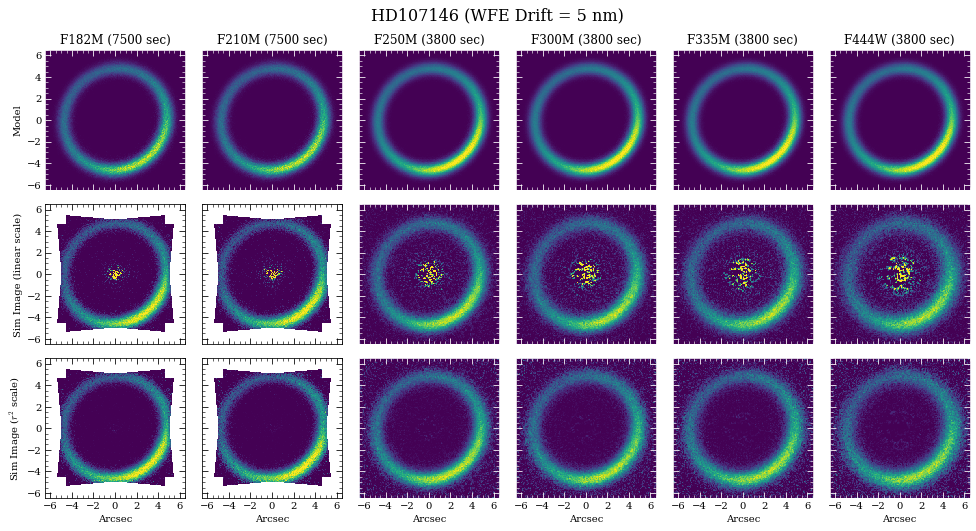

In [39]:
save_fig = True
if len(obs_dict)==2:
    plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_fig)
else:
    plot_images_swlw(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_fig)

In [40]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_dict = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, exclude_disk=False)
curves_F444W = curves_dict[filt_keys[-1]]

# Roll1 - Roll2
curves_dict = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, exclude_disk=False,
                          no_ref=True)
curves_F444W2 = curves_dict[filt_keys[-1]]

F444W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


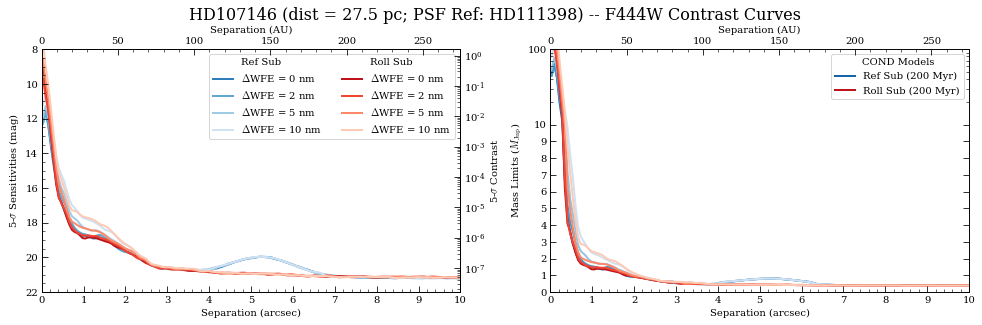

In [41]:
sat_rad = 0
obs = obs_dict[filt_keys[-1]]
do_plot_contrasts(curves_F444W, curves_F444W2, obs, save_fig=True)

## HD 181327

In [42]:
# Fit spectrum to SED photometry
from pynrc.nrc_utils import source_spectrum

i=2
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci, fov = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,4])

# Final source spectrum
sp_sci = src.sp_model

[0.97349543]


In [43]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True)

# Final reference spectrum
sp_ref = ref.sp_model

[0.92729568]


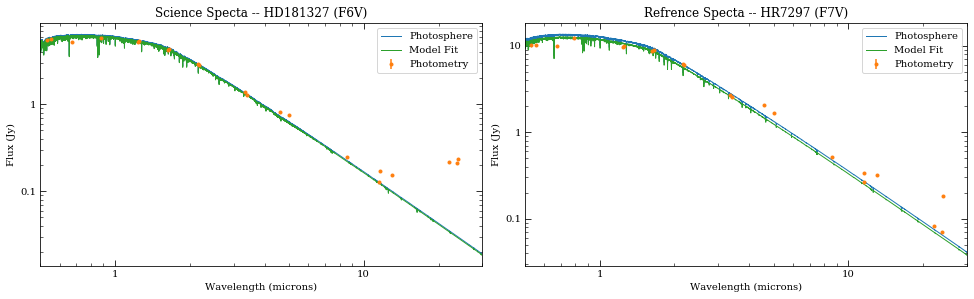

In [44]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Refrence Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

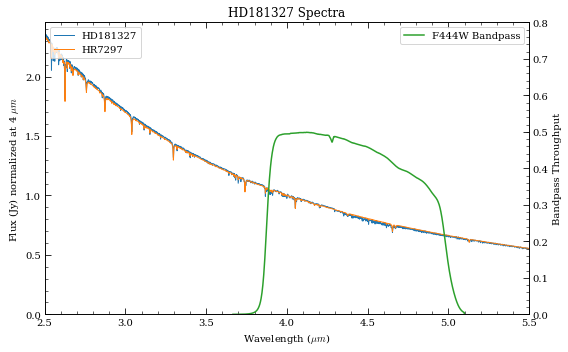

In [45]:
# Plot the two spectra
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3.9) & (w<=4.1)
    sp.convert('Jy')
    f = sp.flux / np.mean(sp.flux[ind2])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    ax.set_ylabel('Flux (Jy) normalized at 4 $\mu m$')
    sp.convert('flam')

ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
bp = pynrc.read_filter(*args_filter[-1])
ax2 = ax.twinx()
ax2.plot(bp.wave/1e4, bp.throughput, color='C2', label=bp.name+' Bandpass')
ax2.set_ylim([0,0.8])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_2SEDs.pdf'.format(name_sci.replace(' ','')))

In [46]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F182M_MASK335R_CIRCLYOT
F210M_MASK335R_CIRCLYOT
F250M_MASK335R_CIRCLYOT
F300M_MASK335R_CIRCLYOT
F335M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [47]:
# Optimize readout parameters
tacq = 4200
#do_opt(tacq, patterns='MEDIUM8', ng_min=8, ng_max=8, tacq_frac=0.1, well_levels=[2], even_nints=True)

In [48]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    ng, nint_sci, nint_ref = (10,15,20)
    if obs.bandpass.avgwave()/1e4 < 2.5: 
        nint_sci *= 2
        nint_ref *= 2
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_ref)

    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')


In [49]:
# Saturation Levels
# Only want F444W
#obs = obs_dict[filt_keys[-1]]
#sat_rad = do_sat_levels(obs, plot=True)

# Max Saturation Values
dmax = []
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    
    imsci = obs.gen_slope_image(exclude_noise=True, quick_PSF=True)
    imref = obs.gen_slope_image(exclude_noise=True, quick_PSF=True, do_ref=True)
    
    ng1 = 2
    ng2 = obs.multiaccum.ngroup
    sci_sat1 = obs.saturation_levels(ngroup=ng1, image=imsci)
    sci_sat2 = obs.saturation_levels(ngroup=ng2, image=imsci)
    ref_sat1 = obs.saturation_levels(ngroup=ng1, image=imref, do_ref=True)
    ref_sat2 = obs.saturation_levels(ngroup=ng2, image=imref, do_ref=True)
    
    print('Max Sat NG={}: {:.2f} {:.2f};   Max Sat NG={}: {:.2f} {:.2f}'\
          .format(ng1,sci_sat1.max(),ref_sat1.max(),ng2,sci_sat2.max(),ref_sat2.max()))


F182M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.12 0.24;   Max Sat NG=10: 0.63 1.29
F210M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.13 0.27;   Max Sat NG=10: 0.72 1.45
F250M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.08 0.15;   Max Sat NG=10: 0.41 0.83
F300M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.05 0.11;   Max Sat NG=10: 0.29 0.59
F335M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.04 0.09;   Max Sat NG=10: 0.23 0.46
F444W_MASK335R_CIRCLYOT
Max Sat NG=2: 0.03 0.05;   Max Sat NG=10: 0.15 0.30


In [50]:
# Disk Images
wfe_drift = 5
hdu_dict = do_gen_hdus(obs_dict, wfe_drift, opt_diff=False)

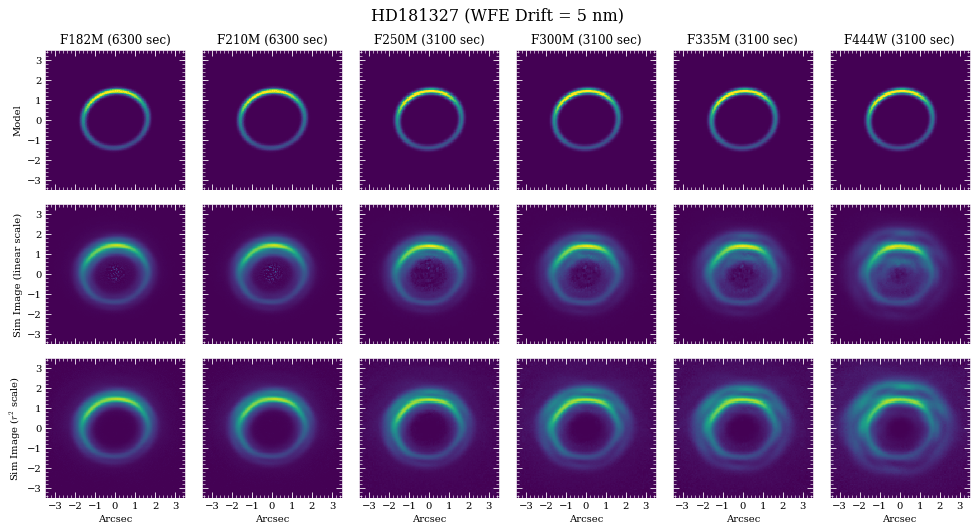

In [51]:
save_fig = True
if len(obs_dict)==2:
    plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_fig)
else:
    plot_images_swlw(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_fig)

In [52]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_dict = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, exclude_disk=False)
curves_F444W = curves_dict[filt_keys[-1]]

# Roll1 - Roll2
curves_dict = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, exclude_disk=False,
                          no_ref=True)
curves_F444W2 = curves_dict[filt_keys[-1]]

F444W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


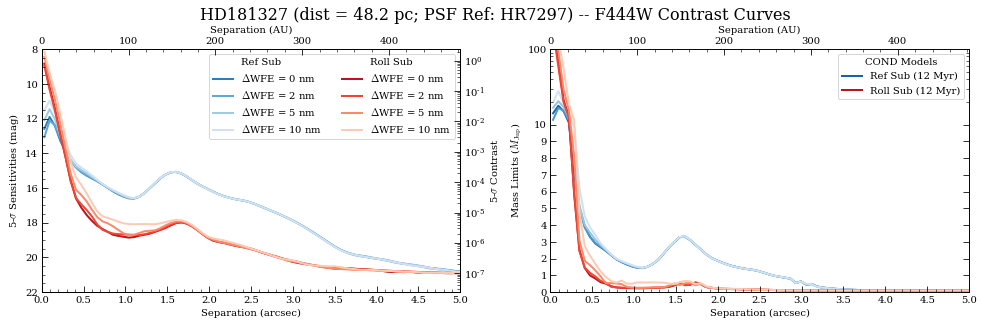

In [53]:
sat_rad = 0
obs = obs_dict[filt_keys[-1]]
do_plot_contrasts(curves_F444W, curves_F444W2, obs, save_fig=True, xr=[0,5], xr2=[0,5])

## HD 61005

In [54]:
# Fit spectrum to SED photometry
from pynrc.nrc_utils import source_spectrum

i=3
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci, fov = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,4])

# Final source spectrum
sp_sci = src.sp_model

[0.96681562]


In [55]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True)

# Final reference spectrum
sp_ref = ref.sp_model

[0.9238596]


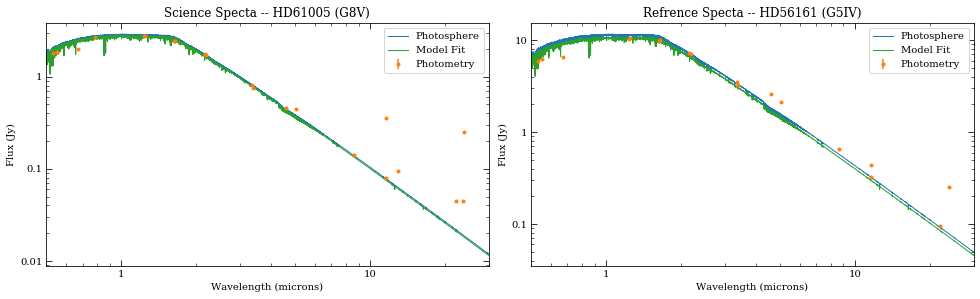

In [56]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Refrence Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

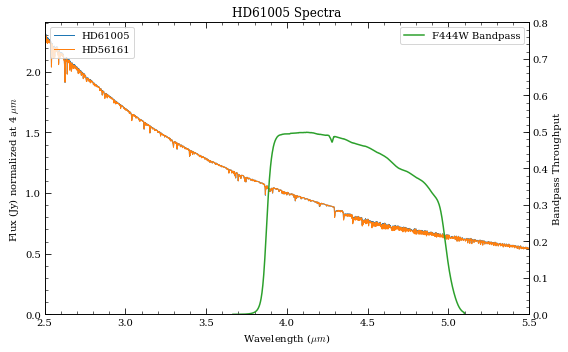

In [57]:
# Plot the two spectra
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3.9) & (w<=4.1)
    sp.convert('Jy')
    f = sp.flux / np.mean(sp.flux[ind2])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    ax.set_ylabel('Flux (Jy) normalized at 4 $\mu m$')
    sp.convert('flam')

ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
bp = pynrc.read_filter(*args_filter[-1])
ax2 = ax.twinx()
ax2.plot(bp.wave/1e4, bp.throughput, color='C2', label=bp.name+' Bandpass')
ax2.set_ylim([0,0.8])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_2SEDs.pdf'.format(name_sci.replace(' ','')))

In [58]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F182M_MASK335R_CIRCLYOT
F210M_MASK335R_CIRCLYOT
F250M_MASK335R_CIRCLYOT
F300M_MASK335R_CIRCLYOT
F335M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [59]:
# Optimize readout parameters
tacq = 4200
#do_opt(tacq, patterns='MEDIUM8', ng_min=8, ng_max=8, tacq_frac=0.1, well_levels=[2], even_nints=True)

In [60]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    ng, nint_sci, nint_ref = (10,15,20)
    if obs.bandpass.avgwave()/1e4 < 2.5: 
        nint_sci *= 2
        nint_ref *= 2
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_ref)

    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')


In [61]:
# Saturation Levels
# Only want F444W
#obs = obs_dict[filt_keys[-1]]
#sat_rad = do_sat_levels(obs, plot=True)

# Max Saturation Values
dmax = []
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    
    imsci = obs.gen_slope_image(exclude_noise=True, quick_PSF=True)
    imref = obs.gen_slope_image(exclude_noise=True, quick_PSF=True, do_ref=True)
    
    ng1 = 2
    ng2 = obs.multiaccum.ngroup
    sci_sat1 = obs.saturation_levels(ngroup=ng1, image=imsci)
    sci_sat2 = obs.saturation_levels(ngroup=ng2, image=imsci)
    ref_sat1 = obs.saturation_levels(ngroup=ng1, image=imref, do_ref=True)
    ref_sat2 = obs.saturation_levels(ngroup=ng2, image=imref, do_ref=True)
    
    print('Max Sat NG={}: {:.2f} {:.2f};   Max Sat NG={}: {:.2f} {:.2f}'\
          .format(ng1,sci_sat1.max(),ref_sat1.max(),ng2,sci_sat2.max(),ref_sat2.max()))


F182M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.07 0.28;   Max Sat NG=10: 0.38 1.52
F210M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.08 0.32;   Max Sat NG=10: 0.44 1.72
F250M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.05 0.18;   Max Sat NG=10: 0.25 0.97
F300M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.03 0.13;   Max Sat NG=10: 0.18 0.70
F335M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.03 0.10;   Max Sat NG=10: 0.14 0.56
F444W_MASK335R_CIRCLYOT
Max Sat NG=2: 0.02 0.06;   Max Sat NG=10: 0.09 0.35


In [62]:
# Disk Images
wfe_drift = 5
hdu_dict = do_gen_hdus(obs_dict, wfe_drift, PA1=-5, PA2=5, use_cmask=True, opt_diff=False)

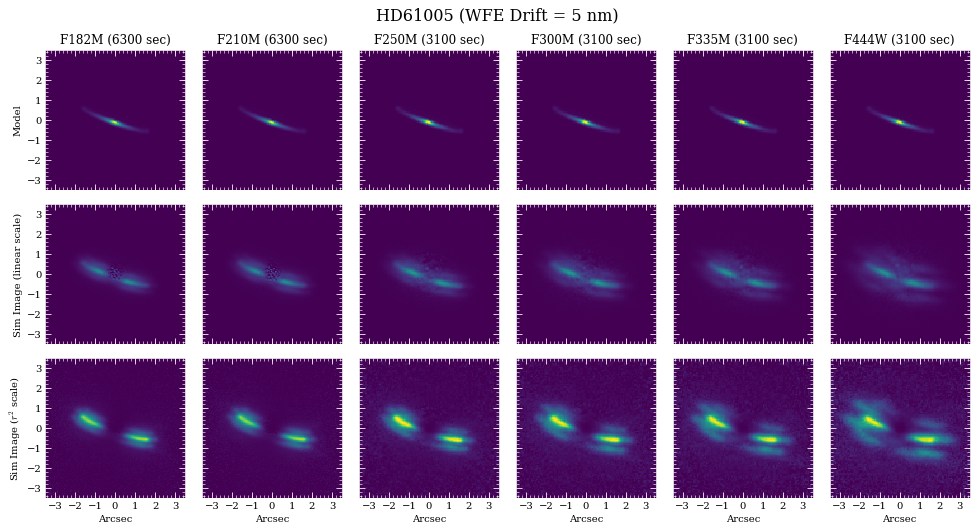

In [63]:
save_fig = True
if len(obs_dict)==2:
    plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_fig)
else:
    plot_images_swlw(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_fig)

In [64]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_dict = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, exclude_disk=False)
curves_F444W = curves_dict[filt_keys[-1]]

# Roll1 - Roll2
curves_dict = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, exclude_disk=False,
                          no_ref=True)
curves_F444W2 = curves_dict[filt_keys[-1]]

F444W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


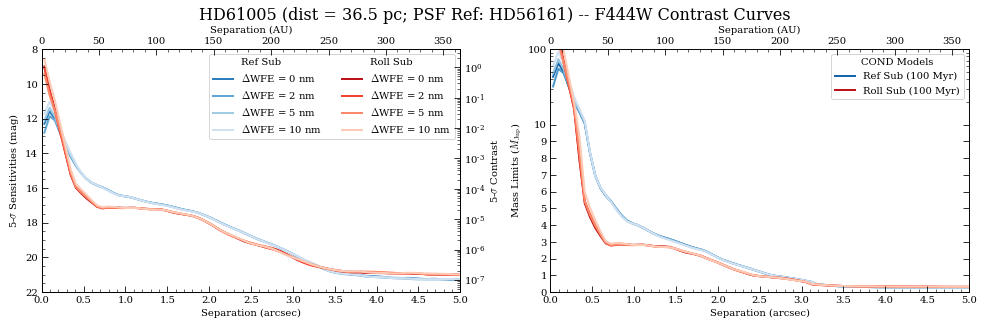

In [65]:
sat_rad = 0
obs = obs_dict[filt_keys[-1]]
do_plot_contrasts(curves_F444W, curves_F444W2, obs, save_fig=True, xr=[0,5], xr2=[0,5])

## HD 32297

In [66]:
# Fit spectrum to SED photometry
from pynrc.nrc_utils import source_spectrum

i=4
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci, fov = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,4])

# Final source spectrum
sp_sci = src.sp_model

[0.99412904]


In [67]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True)

# Final reference spectrum
sp_ref = ref.sp_model

[0.93365695]


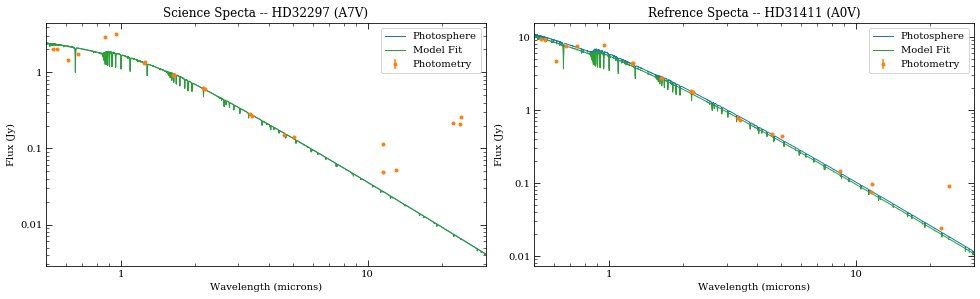

In [68]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Refrence Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

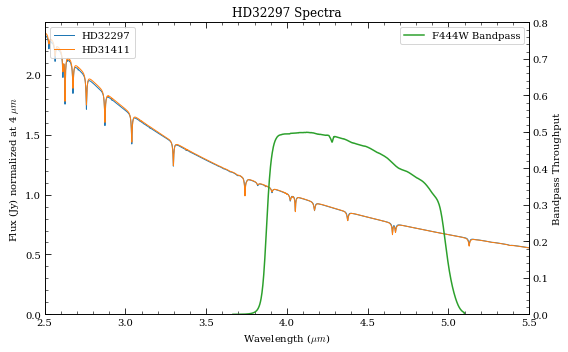

In [69]:
# Plot the two spectra
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3.9) & (w<=4.1)
    sp.convert('Jy')
    f = sp.flux / np.mean(sp.flux[ind2])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    ax.set_ylabel('Flux (Jy) normalized at 4 $\mu m$')
    sp.convert('flam')

ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
bp = pynrc.read_filter(*args_filter[-1])
ax2 = ax.twinx()
ax2.plot(bp.wave/1e4, bp.throughput, color='C2', label=bp.name+' Bandpass')
ax2.set_ylim([0,0.8])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_2SEDs.pdf'.format(name_sci.replace(' ','')))

In [70]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F182M_MASK335R_CIRCLYOT
F210M_MASK335R_CIRCLYOT
F250M_MASK335R_CIRCLYOT
F300M_MASK335R_CIRCLYOT
F335M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [71]:
# Optimize readout parameters
tacq = 4200
#do_opt(tacq, patterns='MEDIUM8', ng_min=8, ng_max=8, tacq_frac=0.1, well_levels=[2], even_nints=True)

In [73]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    ng, nint_sci, nint_ref = (10,16,20)
    if obs.bandpass.avgwave()/1e4 < 2.5:
        nint_sci *= 2
        nint_ref *= 2
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_ref)

    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')


In [74]:
# Saturation Levels
# Only want F444W
#obs = obs_dict[filt_keys[-1]]
#sat_rad = do_sat_levels(obs, plot=True)

# Max Saturation Values
dmax = []
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    
    imsci = obs.gen_slope_image(exclude_noise=True, quick_PSF=True)
    imref = obs.gen_slope_image(exclude_noise=True, quick_PSF=True, do_ref=True)
    
    ng1 = 2
    ng2 = obs.multiaccum.ngroup
    sci_sat1 = obs.saturation_levels(ngroup=ng1, image=imsci)
    sci_sat2 = obs.saturation_levels(ngroup=ng2, image=imsci)
    ref_sat1 = obs.saturation_levels(ngroup=ng1, image=imref, do_ref=True)
    ref_sat2 = obs.saturation_levels(ngroup=ng2, image=imref, do_ref=True)
    
    print('Max Sat NG={}: {:.2f} {:.2f};   Max Sat NG={}: {:.2f} {:.2f}'\
          .format(ng1,sci_sat1.max(),ref_sat1.max(),ng2,sci_sat2.max(),ref_sat2.max()))


F182M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.03 0.07;   Max Sat NG=10: 0.14 0.39
F210M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.03 0.08;   Max Sat NG=10: 0.16 0.43
F250M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.02 0.05;   Max Sat NG=10: 0.09 0.25
F300M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.01 0.03;   Max Sat NG=10: 0.06 0.17
F335M_MASK335R_CIRCLYOT
Max Sat NG=2: 0.01 0.03;   Max Sat NG=10: 0.05 0.14
F444W_MASK335R_CIRCLYOT
Max Sat NG=2: 0.01 0.02;   Max Sat NG=10: 0.03 0.09


In [75]:
# Disk Images
wfe_drift = 5
hdu_dict = do_gen_hdus(obs_dict, wfe_drift, opt_diff=False, ref_scale_all=False, oversample=2)

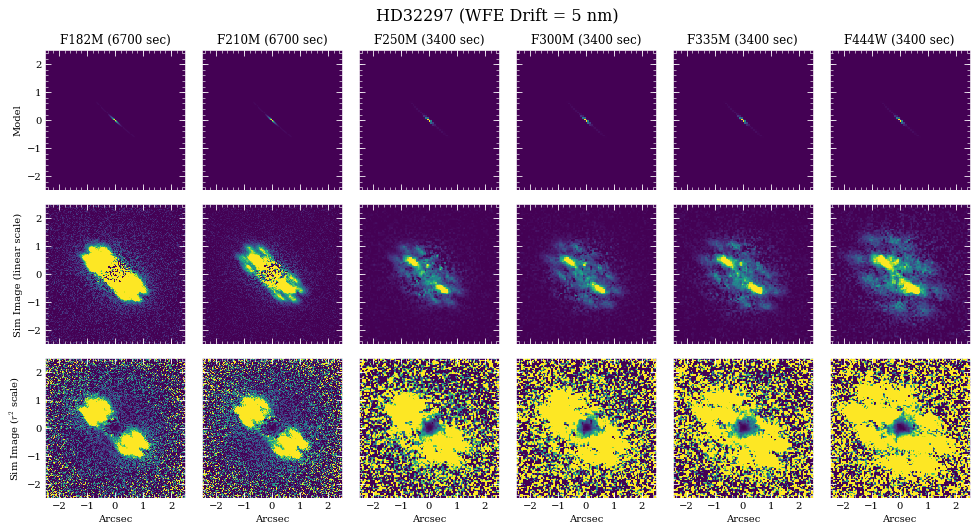

In [76]:
save_fig = True
if len(obs_dict)==2:
    plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_fig)
else:
    plot_images_swlw(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_fig)

In [77]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_dict = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, exclude_disk=False)
curves_F444W = curves_dict[filt_keys[-1]]

# Roll1 - Roll2
curves_dict = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, exclude_disk=False,
                          no_ref=True)
curves_F444W2 = curves_dict[filt_keys[-1]]

F444W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


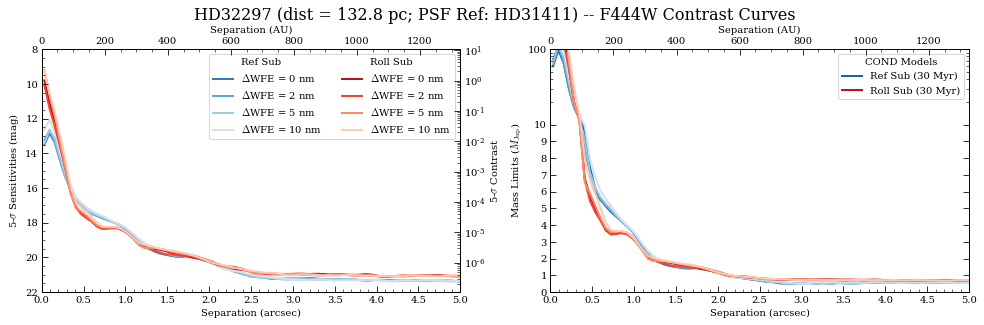

In [78]:
sat_rad = 0
obs = obs_dict[filt_keys[-1]]
do_plot_contrasts(curves_F444W, curves_F444W2, obs, save_fig=True, xr=[0,5], xr2=[0,5])

In [79]:
obs.multiaccum_times

{'t_frame': 1.06904,
 't_group': 10.6904,
 't_int': 104.76592,
 't_exp': 1676.25472,
 't_acq': 1693.67808,
 't_int_tot': 105.85488}